In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder, OneHotEncoder

In [4]:
dtype=dict(MONTH=np.int32, DAY_OF_WEEK=np.int32, FL_NUM=np.int32)

df = pd.read_csv("data/aggregated.csv", dtype=dtype)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5129354 entries, 0 to 5129353
Data columns (total 14 columns):
MONTH               int32
DAY_OF_WEEK         int32
FL_DATE             object
UNIQUE_CARRIER      object
FL_NUM              int32
ORIGIN              object
ORIGIN_CITY_NAME    object
DEST                object
DEST_CITY_NAME      object
CRS_DEP_TIME        float64
ARR_DEL15           float64
CRS_ELAPSED_TIME    float64
DISTANCE            float64
Unnamed: 13         float64
dtypes: float64(5), int32(3), object(6)
memory usage: 489.2+ MB


In [6]:
df.head(10)

,MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,CRS_DEP_TIME,ARR_DEL15,CRS_ELAPSED_TIME,DISTANCE,Unnamed: 13
0,2,6,2017-02-25,B6,28,MCO,"Orlando, FL",EWR,"Newark, NJ",1000.0,0.0,156.0,937.0,NaN
1,2,7,2017-02-26,B6,28,MCO,"Orlando, FL",EWR,"Newark, NJ",739.0,0.0,153.0,937.0,NaN
2,2,1,2017-02-27,B6,28,MCO,"Orlando, FL",EWR,"Newark, NJ",1028.0,0.0,158.0,937.0,NaN
3,2,2,2017-02-28,B6,28,MCO,"Orlando, FL",EWR,"Newark, NJ",739.0,0.0,153.0,937.0,NaN
4,2,3,2017-02-01,B6,33,BTV,"Burlington, VT",JFK,"New York, NY",1907.0,0.0,90.0,266.0,NaN
5,2,4,2017-02-02,B6,33,BTV,"Burlington, VT",JFK,"New York, NY",1907.0,0.0,90.0,266.0,NaN
6,2,5,2017-02-03,B6,33,BTV,"Burlington, VT",JFK,"New York, NY",1907.0,0.0,90.0,266.0,NaN
7,2,6,2017-02-04,B6,33,BTV,"Burlington, VT",JFK,"New York, NY",1907.0,0.0,90.0,266.0,NaN
8,2,7,2017-02-05,B6,33,BTV,"Burlington, VT",JFK,"New York, NY",1907.0,0.0,90.0,266.0,NaN
9,2,1,2017-02-06,B6,33,BTV,"Burlington, VT",JFK,"New York, NY",1907.0,1.0,90.0,266.0,NaN


Break up
* FL_DATE
    * Extract year
    * Extract week
* CRS_DEP_TIME
    * DEP_HOUR
    * DEP_MIN15

One hot encode:
* YEAR
* WEEK
* MONTH
* DAY_OF_WEEK
* UNIQUE_CARRIER
* ORIGIN
* ORIGIN_CITY_NAME
* DEST
* DEST_CITY_NAME
* DEP_HOUR
* DEP_MIN15

Dont change
* DISTANCE
* CRS_ELAPSED_TIME

Unknown
* FL_NUM - probably drop

In [97]:
def clean_data(df, oe_dict=None): 
    drop_columns = ['Unnamed: 13', 'UNIQUE_CARRIER', 'ORIGIN', 'CRS_DEP_TIME',
                    'ORIGIN_CITY_NAME', 'DEST', 'DEST_CITY_NAME', 'FL_DATE', 'FL_NUM']

    df["YEAR"] = df.apply(lambda row: int(row.FL_DATE.split('-')[0]), axis=1)
    df["WEEK"] = df.apply(lambda row: int(row.FL_DATE.split('-')[2]) // 6, axis=1)
    df["DEP_HOUR"] = df.apply(lambda row: row.CRS_DEP_TIME // 100, axis=1)
    df["DEP_MIN15"] = df.apply(lambda row: (row.CRS_DEP_TIME % 100) // 15, axis=1)
    
    # Binarize depart time
    #disc = KBinsDiscretizer(n_bins=24*4, encode='onehot', strategy='uniform')
    #X = disc.fit_transform(df.CRS_DEP_TIME.values.reshape(-1,1))
    #dfKDisc = pd.DataFrame(X, columns=[i for i in range(96)])

    # Encode columns
    new_oe = False
    if oe_dict == None:
        new_oe = True
        
    if oe_dict == None:
        oe_dict =\
            {'UNIQUE_CARRIER': OneHotEncoder(categories='auto', dtype=np.int8),
             'ORIGIN': OneHotEncoder(categories='auto', dtype=np.int16),
             'ORIGIN_CITY_NAME': OneHotEncoder(categories='auto', dtype=np.int16),
             'DEST': OneHotEncoder(categories='auto', dtype=np.int16),
             'DEST_CITY_NAME': OneHotEncoder(categories='auto', dtype=np.int16),
             'YEAR': OneHotEncoder(categories='auto', dtype=np.int8),
             'WEEK': OneHotEncoder(categories='auto', dtype=np.int8),
             'DEP_HOUR': OneHotEncoder(categories='auto', dtype=np.int8),
             'DEP_MIN15': OneHotEncoder(categories='auto', dtype=np.int8)
             }
        
    for col, oe in oe_dict.items():
        if new_oe:
            X = oe.fit_transform(df[col].values.reshape(-1,1)).toarray()
        else:
            X = oe.transform(df[col].values.reshape(-1,1)).toarray()
        features = np.array(oe.categories_).ravel()
        #dfOneHot = pd.DataFrame(X, columns=features)
        dfOneHot = pd.DataFrame(X, columns=[col+"_"+str(i) for i in range(len(features))])

        df = pd.concat([df, dfOneHot], axis=1)


    df = df.drop(columns=drop_columns)

    return df, oe_dict

In [98]:
clean_df, oe_dict = clean_data(df)

In [99]:
clean_df.head()

,MONTH,DAY_OF_WEEK,ARR_DEL15,CRS_ELAPSED_TIME,DISTANCE,DEP_HOUR,DEP_MIN15,UNIQUE_CARRIER_0,UNIQUE_CARRIER_1,UNIQUE_CARRIER_2,...,DEP_HOUR_18,DEP_HOUR_19,DEP_HOUR_20,DEP_HOUR_21,DEP_HOUR_22,DEP_HOUR_23,DEP_MIN15_0,DEP_MIN15_1,DEP_MIN15_2,DEP_MIN15_3
0,2,5,0.0,90.0,266.0,19.0,0.0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
1,2,7,1.0,90.0,266.0,19.0,0.0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
2,2,1,1.0,90.0,266.0,19.0,0.0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
3,2,1,0.0,157.0,857.0,17.0,2.0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,2,2,0.0,81.0,266.0,17.0,0.0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [88]:
clean_df.shape

(570274, 1285)

In [31]:
df.nunique()

MONTH                 11
DAY_OF_WEEK            7
FL_DATE              334
UNIQUE_CARRIER        12
FL_NUM              6774
ORIGIN               309
ORIGIN_CITY_NAME     305
DEST                 310
DEST_CITY_NAME       306
CRS_DEP_TIME        1289
ARR_DEL15              2
CRS_ELAPSED_TIME     546
DISTANCE            1331
Unnamed: 13            0
dtype: int64

In [18]:
df.FL_NUM.unique()

array([  33.,   34.,   42., ..., 4975., 6512., 4943.])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a70b43278>,
      dtype=object)

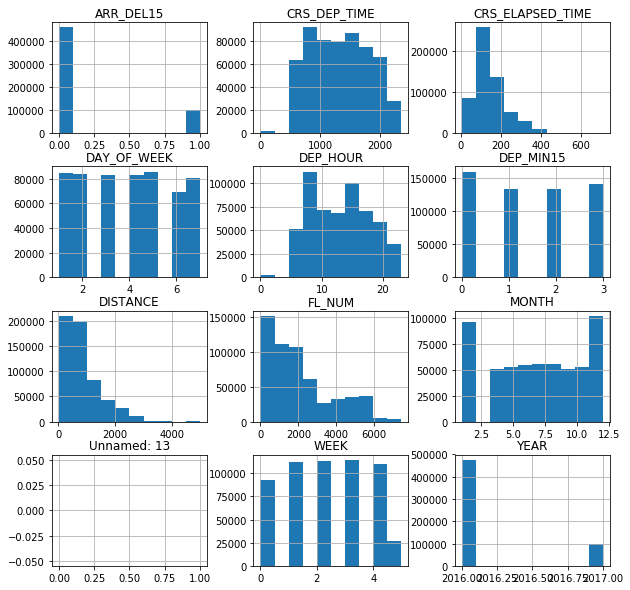

In [87]:
plt.rcParams['figure.figsize'] = [10, 10]
df.hist()

In [91]:
data = clean_df.loc[:, clean_df.columns != "ARR_DEL15"]
target = clean_df["ARR_DEL15"]

In [96]:
data.isnull().values.any()

False

Dimensionality reduction

In [107]:
col = 'ORIGIN'
features = np.array(oe_dict[col].categories_).ravel()
truncate_df = clean_df[[col+"_"+str(i) for i in range(len(features))]]

svd = TruncatedSVD(n_components=len(features)//10, n_iter=7, random_state=42)
svd.fit(truncate_df)  

TruncatedSVD(algorithm='randomized', n_components=30, n_iter=7,
       random_state=42, tol=0.0)

In [111]:
svd.components_.shape

(30, 309)

In [112]:
svd.explained_variance_ratio_.sum()

0.6811074652076912

In [104]:
truncate_df.head()

,ORIGIN_0,ORIGIN_1,ORIGIN_2,ORIGIN_3,ORIGIN_4,ORIGIN_5,ORIGIN_6,ORIGIN_7,ORIGIN_8,ORIGIN_9,...,ORIGIN_299,ORIGIN_300,ORIGIN_301,ORIGIN_302,ORIGIN_303,ORIGIN_304,ORIGIN_305,ORIGIN_306,ORIGIN_307,ORIGIN_308
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570274 entries, 0 to 570273
Data columns (total 18 columns):
MONTH               570274 non-null int32
DAY_OF_WEEK         570274 non-null int32
FL_DATE             570274 non-null object
UNIQUE_CARRIER      570274 non-null object
FL_NUM              570274 non-null int32
ORIGIN              570274 non-null object
ORIGIN_CITY_NAME    570274 non-null object
DEST                570274 non-null object
DEST_CITY_NAME      570274 non-null object
CRS_DEP_TIME        570274 non-null float64
ARR_DEL15           562422 non-null float64
CRS_ELAPSED_TIME    570274 non-null float64
DISTANCE            570274 non-null float64
Unnamed: 13         0 non-null float64
YEAR                570274 non-null int64
WEEK                570274 non-null int64
DEP_HOUR            570274 non-null float64
DEP_MIN15           570274 non-null float64
dtypes: float64(7), int32(3), int64(2), object(6)
memory usage: 71.8+ MB


In [113]:
data = clean_df.loc[:, clean_df.columns != "ARR_DEL15"]
target = clean_df["ARR_DEL15"]

In [114]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(data, target)
#scores = cross_val_score(clf, data, target, cv=5)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').